In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Embedding
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime
from tqdm import tqdm
print(f'Current Step #01 [now = {datetime.now()}')


Current Step #01 [now = 2025-06-26 17:03:43.125369


In [56]:
results = {}

In [57]:
def load_metrics(random_state, version, db_file_path):
    query = f'select rounds, matched_cnts from rndforest where random_state={random_state} and version=\\"{version}\\"'
    metrics = !echo {query} | sqlite3 {db_file_path}
    # print(metrics)
    if len(metrics) > 0:
        metrics = metrics[0].split('|')
        return metrics[0], metrics[1] 
    return [], []


def load_data(version="T_01_10", db_file_path='../db/metrics.db', random_state=113789):
    rounds_str, matched_cnts_str = load_metrics(random_state=random_state, db_file_path=db_file_path, version=version)
    rounds = []
    matched_cnts = []
    if len(rounds_str) > 0 and len(matched_cnts_str) > 0:
        for i in rounds_str.split(','):
            rounds.append(int(i))
        for i in matched_cnts_str.split(','):
            matched_cnts.append(int(i))
        rounds.reverse()
        matched_cnts.reverse()
        df = pd.DataFrame(zip(rounds, matched_cnts), columns=['rounds', 'matched_cnts'])
        return df
    return None


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


print(f'Current Step #01 [now = {datetime.now()}')

Current Step #01 [now = 2025-06-26 17:03:47.431062


In [58]:
time_steps = 10
data_dim = 1
num_samples = 100
X = np.random.rand(num_samples, time_steps, data_dim)
print(len(X))

100


In [96]:
from enum import Enum

class ScalerType(Enum):
    PRIVATE=0,
    STANDARD=1,
    MIN_MAX=2


scaler_cls = {
    ScalerType.PRIVATE: PrivateScaler,
    ScalerType.STANDARD: StandardScaler,
    ScalerType.MIN_MAX: MinMaxScaler # feature_range=(0,1)
    }


class PrivateScaler:
    def __init__(self, divider=6.0):
        """" __init___ """
        self._divider = divider
        self.p_max = 1
        self.p_min = -1
        self.p_mux = 1

    def adjust_parameter(self, data, add_mux):
        if len(data) > 1:
            if self.p_min == -1:
                self.p_min = data.min() * self._divider
                max_diff_val = data.max() * self._divider - self.p_min
                print('min, max, diff', self.p_min, data.max(), max_diff_val)
                while (max_diff_val * self.p_mux) < 0.1:
                    self.p_mux *= 10
                self.p_mux += add_mux
        else:
            pass

    def fit_transform(self, data):
        """ fit_transform """
        self.p_max = data.max() + 1
        self._divider = self.p_max
        scaled_data = np.array([[round(float(i[0])/self._divider, 9)] for i in data])
        return scaled_data

    def inverse_transform(self, data, add_mux=0.):
        """ inverse_transform """
        if data[1]:
            self.adjust_parameter(data[0], add_mux)
            restored = np.array([[((i[0] * self._divider - self.p_min) * self.p_mux)] for i in data[0]])
        else:
            restored = np.array([[i[0] * self._divider] for i in data[0]])
        return restored


class DataScaling():
    def __init__(self, scaler_type: ScalerType, *args: list):
        self._scaler_type = scaler_type
        self._scaler_cls = scaler_cls[scaler_type](*args)

    def fit_transform(self, data):
        return self._scaler_cls.fit_transform(data)

    def inverse_transform(self, datas: list):
        inversed_data = []
        if self._scaler_type == ScalerType.PRIVATE:
            for data in datas:
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform((data[0].reshape(-1, 1), data[2]))
                else:
                    inversed = self._scaler_cls.inverse_transform((data[0], data[2]))
                inversed_data.append(inversed)
        else:
            cnt = 1
            for data in datas:
                cnt += 1
                if data[1] == True:
                    inversed = self._scaler_cls.inverse_transform(data[0].reshape(-1, 1))
                else:
                    inversed = self._scaler_cls.inverse_transform(data[0])
                inversed_data.append(inversed)
        return inversed_data


### 최종 결과 입니다.
def analyze_v1(random_state,
               version,
               db_file_path,
               scaler_type=ScalerType.PRIVATE,
               layers=[(False)],
               activation='sigmoid',
               units=50,
               draw_graph=True,
               sequence_length=10,
               optimizer="adam",
               loss='mean_squared_error',
               add_mux=0,
               verbose=0):
    """
     - loss = [binary_crossentropy, mean_squared_error, ]
     - optimizer = [adam, ]

    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # 1. Prepare the Data
    # Create sample time series data
    df = load_data(version=version, db_file_path=db_file_path, random_state=random_state)
    if df is None:
        return -1, '', random_state

    if verbose > 0:
        print('df', df)
    if verbose > 0:
        print(f'Current Step #02 [now = {datetime.now()}]')

    data = df['matched_cnts'].values.reshape(-1, 1)

    # Normalize the data
    scaler = DataScaling(scaler_type)
    scaled_data = scaler.fit_transform(data)
    if verbose > 0:
        print(f'Current Step #04 [now = {datetime.now()}]')

    # Define sequence length (timesteps)

    # Create sequences for training
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    # print('X=', X)
    # print('y=', y)
    if verbose > 0:
        print(f'Current Step #06 [now = {datetime.now()}]')

    # Reshape X for LSTM input (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    if verbose > 0:
        print(f'Current Step #08 [now = {datetime.now()}]')

    # Split data into training and testing sets
    # train_size = int(len(X) * 0.8)
    train_size = int(len(X) * 0.8)

    X_train, X_test, X_last = X[:train_size], X[train_size:], np.array([[y[-1:]]])
    y_train, y_test = y[:train_size], y[train_size:]
    if verbose > 0:
        print(f'Current Step #10 [now = {datetime.now()}]')

    # print('len (train) = ', len(X_train), len(X_train[0]))
    # print('len (test ) = ', len(X_test), len(X_test[0]))
    # return [], [], [], []
    
    tf.random.set_seed(random_state)

    # 2. Build the LSTM Model
    model = Sequential()
    input_shape = (X_train.shape[1], 1)
    embedding_dim = 1
    max_len = sequence_length
    vocab_size = len(data)
    # print('input_shape', input_shape)
    
    # if is_bidirectional = :
    # else:
    model.add(Input(shape=input_shape))
    for i in range(len(layers)):
        print(f'add layter [{i}]')
        if i < (len(layers) - 1):
            return_sequences=True
        else:
            return_sequences=False
        print(f'Bidirectional = {layers[i][0]}')
        if layers[i][0]==True:
            model.add(Bidirectional(LSTM(units=units,
                                         activation=activation,
                                         return_sequences=return_sequences),))
        else:
            model.add(LSTM(units=units,
                           activation=activation,
                           return_sequences=return_sequences))
                                    # input_shape=input_shape))

    # model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1)) # Output layer for predicting a single value
    if verbose > 0:
        print(f'Current Step #12 [now = {datetime.now()}]')

    # 3. Compile and Train the Model
    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training

    if verbose > 0:
        print(f'Current Step #14 [now = {datetime.now()}]')

    # 4. Make Predictions
    train_predict = model.predict(X_train, verbose=verbose)
    test_predict = model.predict(X_test, verbose=verbose)
    last_predict_0 = model.predict(X_last, verbose=verbose)
    if verbose > 0:
        print(f'Current Step #16 [now = {datetime.now()}]')

    # Inverse transform predictions to original scale
    scaled_data1 = scaled_data
    wanted_datas = [(train_predict, False, True),
                    (test_predict, False, True),
                    (last_predict_0, True, True),
                    (y_train, True, False),
                    (y_test, True, False),
                    (scaled_data, False, False)]
    inversed_datas = scaler.inverse_transform(wanted_datas)
    train_predict = inversed_datas[0]
    test_predict = inversed_datas[1]
    last_predict = inversed_datas[2]
    y_train_original = inversed_datas[3]
    y_test_original = inversed_datas[4]
    scaled_data = inversed_datas[5]

    if verbose > 0:
        print(f'Current Step #18 [now = {datetime.now()}]')

    # 5. Evaluate the Model (Optional, but recommended)
    from sklearn.metrics import mean_squared_error
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))

    if verbose > 0:
        print(f'Current Step #20 [now = {datetime.now()}]')
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
        print(f'random_state = {random_state}')
        print(f'last_prediction = {last_predict}')
        print(f'data_max_val = {scaled_data.max()}')
    # You can also visualize the results
    test_last_predict = test_predict[-1:]
    if draw_graph:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(scaled_data1, label='Original Data')
        plt.plot(np.arange(sequence_length,
                           sequence_length + len(train_predict)),
                 train_predict,
                 label='Train Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict),
                           sequence_length + len(train_predict) + len(test_predict)),
                 test_predict,
                 label='Test Predictions')
        # plt.plot(np.arange(sequence_length + len(train_predict) + len(test_predict),
        #          sequence_length + len(train_predict) + len(test_predict) + len(last_predict)),
        #          last_predict,
        #          label='Last Predictions')
        plt.xlabel(f'{random_state}\'s Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    return {
        "scaled_data_max": scaled_data.max(),
        "last_predict": last_predict,
        "last_predict_or": last_predict_0,
        "test_last_predict": test_last_predict,
        "X_last": X_last,
        "random_state": random_state
    }

print(f'Current work : {datetime.now()}')

Current work : 2025-06-26 18:39:55.400110


In [97]:
version = "T_01_13"
t_version = "T_01_95"
predict_result = []
print(f'Current work : {datetime.now()}')

Current work : 2025-06-26 18:39:56.777841


add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
min, max, diff 1.0467748641967773 0.2619389 0.0009807348251342773
p_mux 1000.0


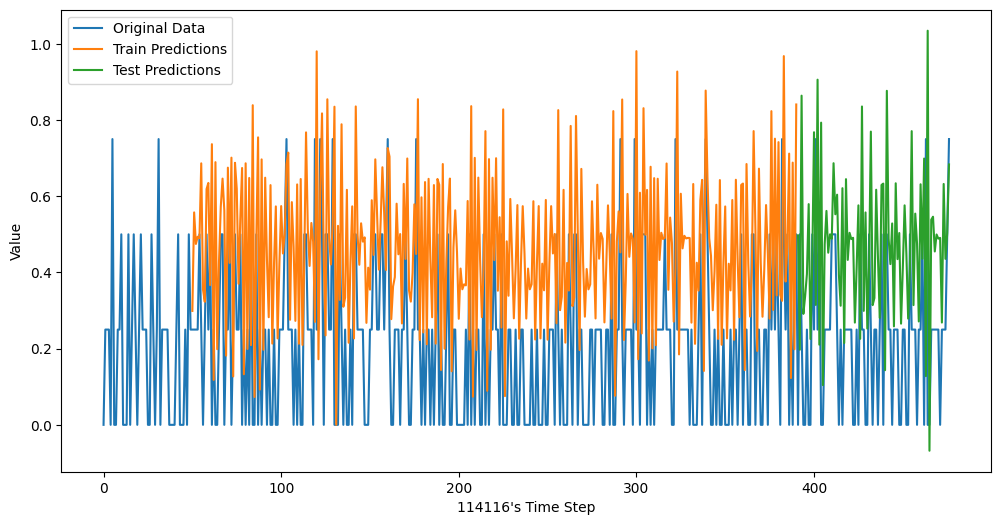

{'scaled_data_max': np.float64(3.0), 'last_predict': array([[62.91949749]]), 'test_last_predict': array([[0.68342686]]), 'X_last': array([[[0.75]]]), 'random_state': 114116} now 2025-06-26 18:43:16.010637


In [98]:
### Good Condition #1
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 45
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
min, max, diff 1.0127068758010864 0.26553208 0.04942142963409424
p_mux 10.0


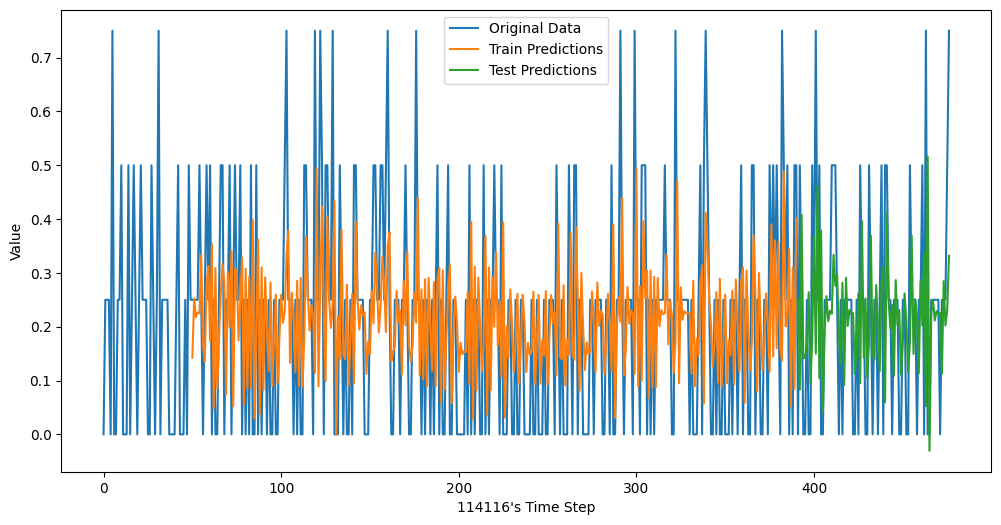

{'scaled_data_max': np.float64(3.0), 'last_predict': array([[-15.81694126]]), 'test_last_predict': array([[0.33173084]]), 'X_last': array([[[0.75]]]), 'random_state': 114116} now 2025-06-26 18:56:27.988329


In [101]:
### Good Condition #1

db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 26
sequence_length = 50

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [ ]:
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 40
sequence_length = 55

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


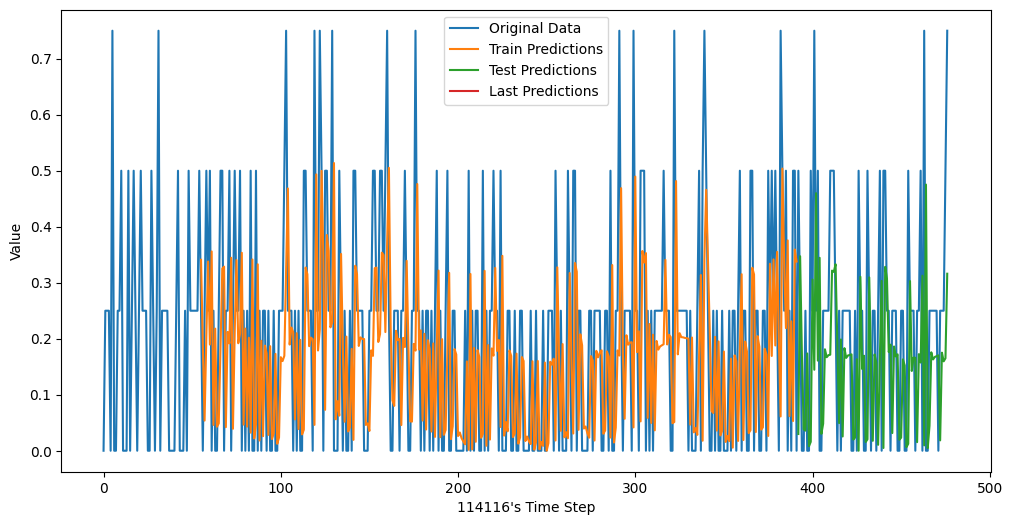

3.0 [[0.14754044]] [[0.31608522]] 114116


In [145]:
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 10
sequence_length = 55
add_mux = 0.3

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
min, max, diff 0.8556569814682007 0.21441817 0.00201570987701416
p_mux 1000.0


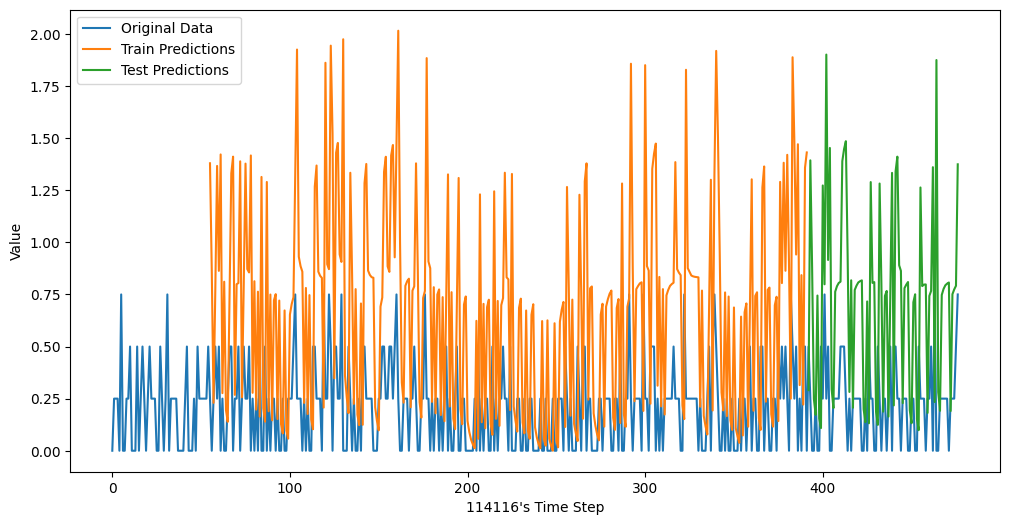

{'scaled_data_max': np.float64(3.0), 'last_predict': array([[-24.55657721]]), 'test_last_predict': array([[1.37454271]]), 'X_last': array([[[0.75]]]), 'random_state': 114116} now 2025-06-26 18:46:18.280413


In [99]:
### good
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


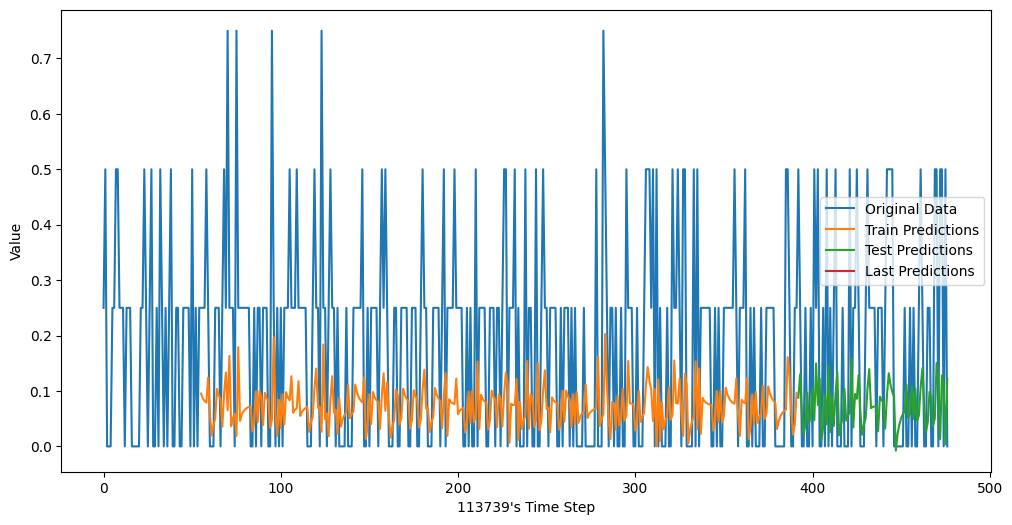

{'scaled_data_max': np.float64(222.44104743003845), 'last_predict': array([[0.67307514]]), 'test_last_predict': array([[0.1224637]]), 'X_last': array([[[0.]]]), 'random_state': 113739} now 2025-06-26 14:01:59.001947


In [23]:
### good
db_file_path = '../db/metrics.db'
random_state = 113739
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3

result = analyze_v1(random_state=random_state,
                    version=t_version,
                    db_file_path=db_file_path,
                    scaler_type=scaler_type,
                    layers=layers,
                    activation=activation,
                    units=units,
                    sequence_length=sequence_length,
                    add_mux=add_mux,
                    verbose=0,
                    )
print(result, f"now {datetime.now()}")
predict_result.append((result["scaled_data_max"],
                       result["last_predict"],
                       result["test_last_predict"],
                       result["random_state"],
                       units,
                       sequence_length, activation))

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


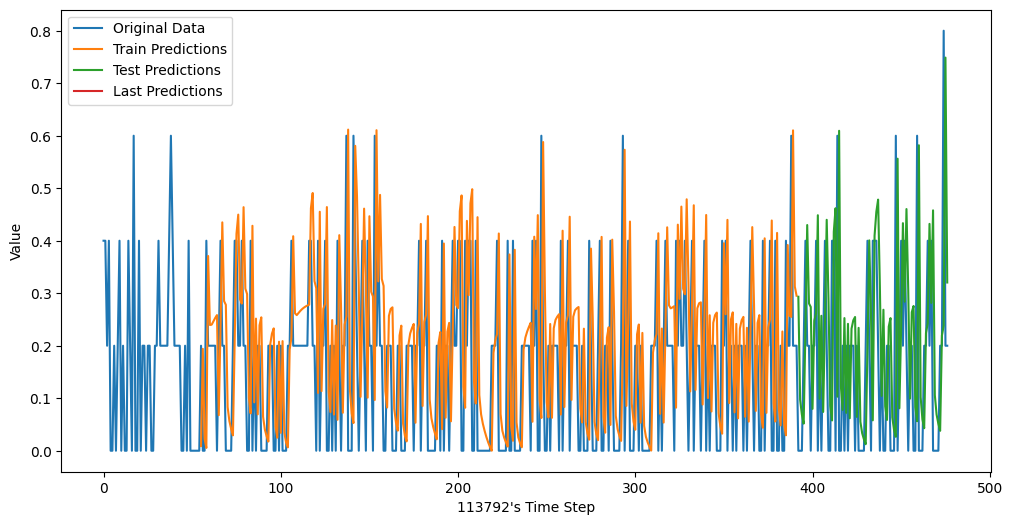

320.3493371605873 [[0.47589194]] [[0.32043457]] 113792 [[[0.2]]] now 2025-06-26 13:54:09.293389


In [20]:
### good
# 6 113575 T_01_13 15
db_file_path = '../db/metrics.db'
random_state = 113792
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3

scaled_data_max, last_predict, test_last_predict, X_new, random_state = analyze_v1(random_state=random_state,
                                                                            version=t_version,
                                                                            db_file_path=db_file_path,
                                                                            scaler_type=scaler_type,
                                                                            layers=layers,
                                                                            activation=activation,
                                                                            units=units,
                                                                            sequence_length=sequence_length,
                                                                            add_mux=add_mux,
                                                                            verbose=0,
                                                                           )
print(results, f"now {datetime.now()}")
predict_result.append((result["scaled_data_max"],
                       result["last_predict"],
                       result["test_last_predict"],
                       result["random_state"],
                       units,
                       sequence_length, activation))

In [17]:
### good
db_file_path = '../db/metrics.db'
random_state = 113575
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

ValueError: not enough values to unpack (expected 5, got 3)

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


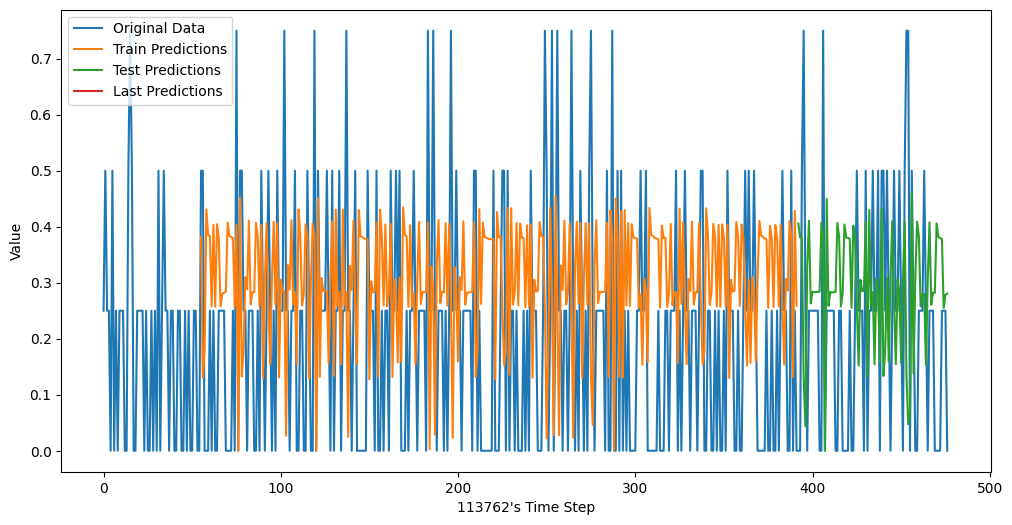

3.0 [[0.73341995]] [[0.2804935]] 113762 [[[0.]]] now 2025-06-26 01:17:20.165468


In [14]:
### good
db_file_path = '../db/metrics.db'
random_state = 113762
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


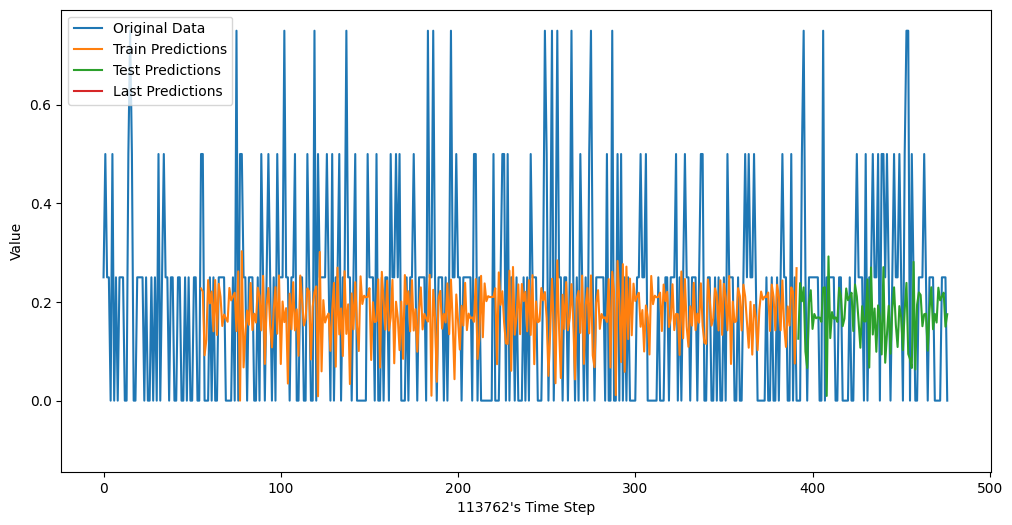

2346.355974674225 [[-0.1015659]] [[0.17517805]] 113762 [[[0.]]] now 2025-06-26 13:43:39.069030


In [16]:
### good
## 2 113762 T_01_13 14
db_file_path = '../db/metrics.db'
random_state = 113762
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 25
sequence_length = 55
add_mux = 0.3

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


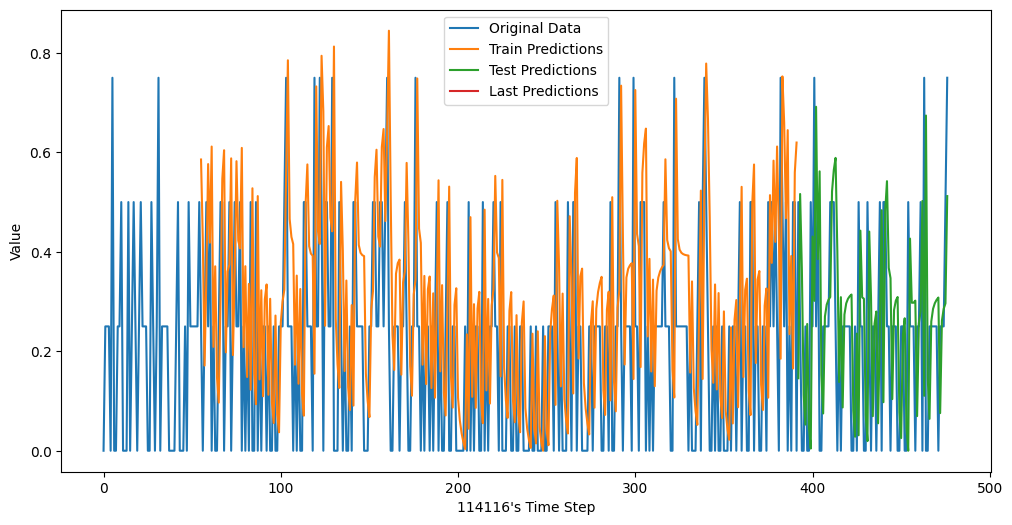

3.0 [[0.72520036]] [[0.5120039]] 114116 [[[0.75]]] now 2025-06-26 00:16:40.489201


NameError: name 'predict_result' is not defined

In [10]:
### Good
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3

results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

now 2025-06-25 14:27:40.568397
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


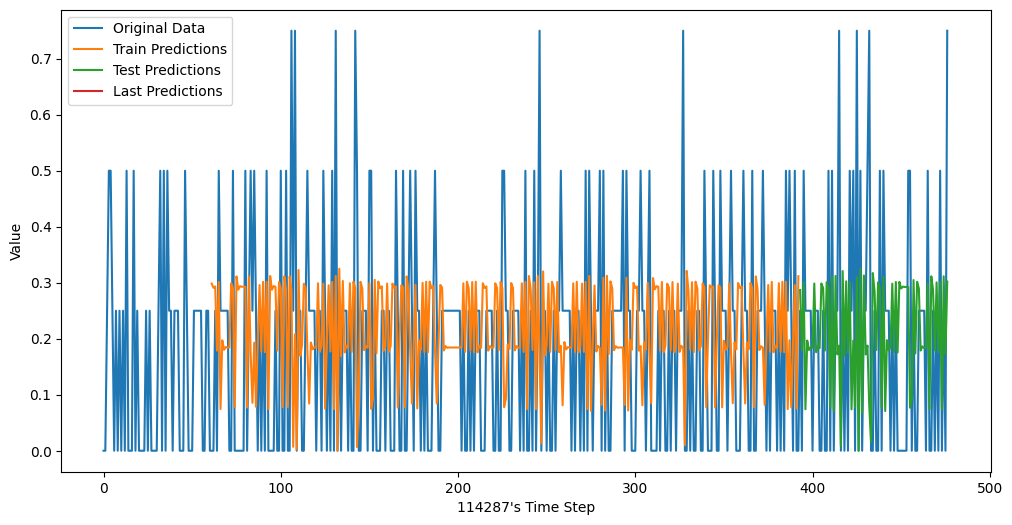

3.0 [[0.7222048]] [[0.30203223]] 114287 [[[0.75]]] now 2025-06-25 14:31:46.294677


In [158]:
### Good
t_version='T_01_95'
db_file_path = '../db/metrics.db'
random_state = 114287
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 40
sequence_length = 61
add_mux = 0.3
print(f"now {datetime.now()}")
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

now 2025-06-25 18:39:34.576915
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


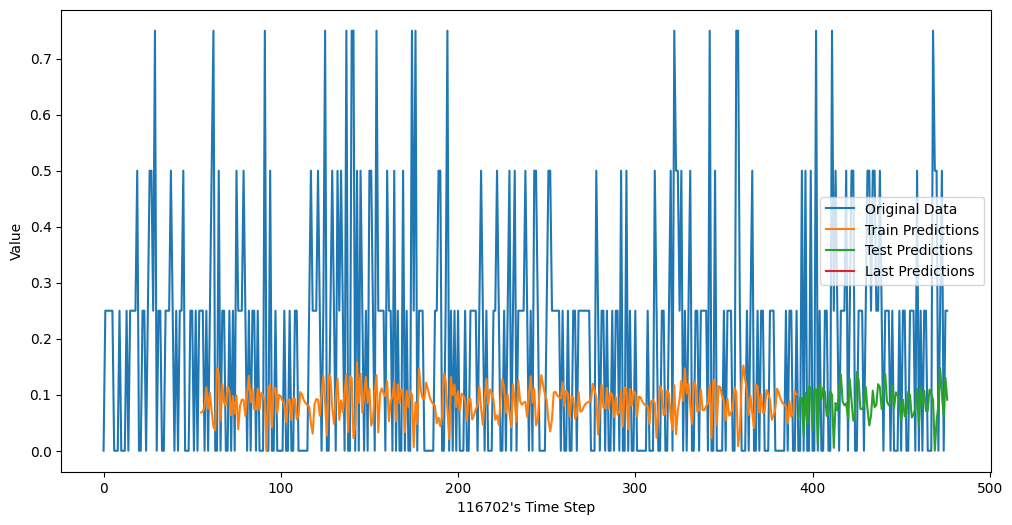

3.0 [[0.55229318]] [[0.0910759]] 116702 [[[0.25]]] now 2025-06-25 18:42:53.627335


In [169]:
### Good
t_version='T_01_95'
db_file_path = '../db/metrics.db'
random_state = 116702
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3
print(f"now {datetime.now()}")
results = analyze_v1(random_state=random_state,
                     version=t_version,
                     db_file_path=db_file_path,
                     scaler_type=scaler_type,
                     layers=layers,
                     activation=activation,
                     units=units,
                     sequence_length=sequence_length,
                     add_mux=add_mux,
                     verbose=0,
                     )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

now 2025-06-25 18:48:59.613489
add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


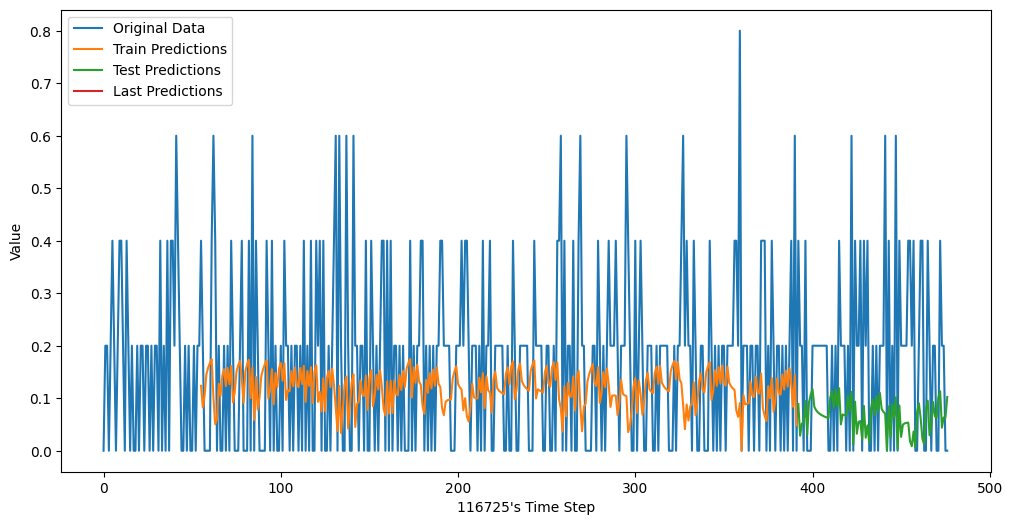

4.0 [[0.76244451]] [[0.10240227]] 116725 [[[0.]]] now 2025-06-25 18:52:17.479513


In [170]:
### Good
t_version='T_01_95'
db_file_path = '../db/metrics.db'
random_state = 116725
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 2
sequence_length = 55
add_mux = 0.3
print(f"now {datetime.now()}")
scaled_data_max, last_predict, test_last_predict, X_new, random_state = analyze_v1(random_state=random_state,
                                                                                   version=t_version,
                                                                                   db_file_path=db_file_path,
                                                                                   scaler_type=scaler_type,
                                                                                   layers=layers,
                                                                                   activation=activation,
                                                                                   units=units,
                                                                                   sequence_length=sequence_length,
                                                                                   add_mux=add_mux,
                                                                                   verbose=0,
                                                                                   )
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

add layter [0]
Bidirectional = True
add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False


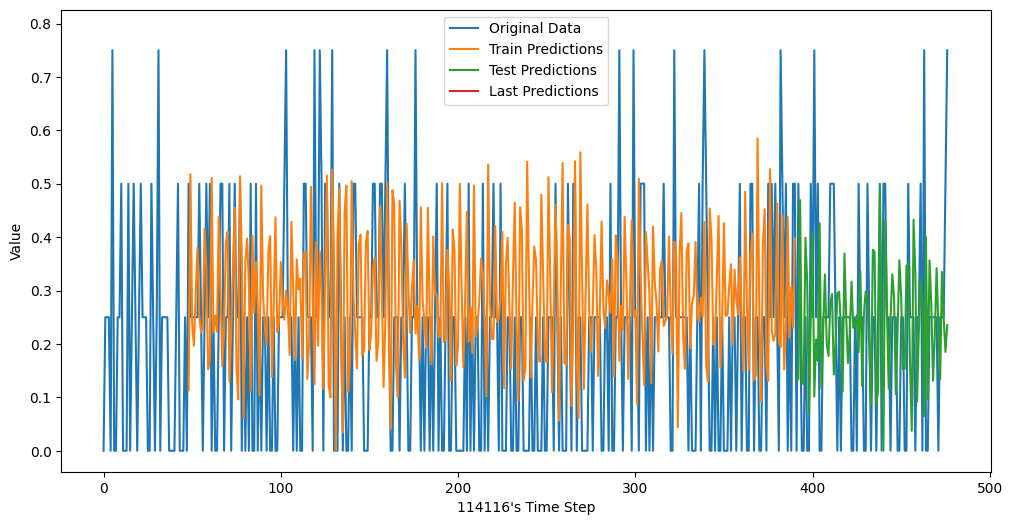

NameError: name 'ᅦ갸ᅮᄉ' is not defined

In [141]:
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,)]
activation = 'sigmoid'
units = 40
sequence_length = 48

scaled_data_max, last_predict, test_last_predict, random_state = analyze_v1(random_state=random_state,
                                                                            version=t_version,
                                                                            db_file_path=db_file_path,
                                                                            scaler_type=scaler_type,
                                                                            layers=layers,
                                                                            activation=activation,
                                                                            units=units,
                                                                            sequence_length=sequence_length,
                                                                            verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

['1177,1176,1175,1174,1173,1172,1171,1170,1169,1168,1167,1166,1165,1164,1163,1162,1161,1160,1159,1158,1157,1156,1155,1154,1153,1152,1151,1150,1149,1148,1147,1146,1145,1144,1143,1142,1141,1140,1139,1138,1137,1136,1135,1134,1133,1132,1131,1130,1129,1128,1127,1126,1125,1124,1123,1122,1121,1120,1119,1118,1117,1116,1115,1114,1113,1112,1111,1110,1109,1108,1107,1106,1105,1104,1103,1102,1101,1100,1099,1098,1097,1096,1095,1094,1093,1092,1091,1090,1089,1088,1087,1086,1085,1084,1083,1082,1081,1080,1079,1078,1077,1076,1075,1074,1073,1072,1071,1070,1069,1068,1067,1066,1065,1064,1063,1062,1061,1060,1059,1058,1057,1056,1055,1054,1053,1052,1051,1050,1049,1048,1047,1046,1045,1044,1043,1042,1041,1040,1039,1038,1037,1036,1035,1034,1033,1032,1031,1030,1029,1028,1027,1026,1025,1024,1023,1022,1021,1020,1019,1018,1017,1016,1015,1014,1013,1012,1011,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001,1000,999,998,997,996,995,994,993,992,991,990,989,988,987,986,985,984,983,982,981,980,979,978,977,976,975,974,973,

/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


add layter [1]
Bidirectional = False
add layter [2]
Bidirectional = False
add layter [3]
Bidirectional = False


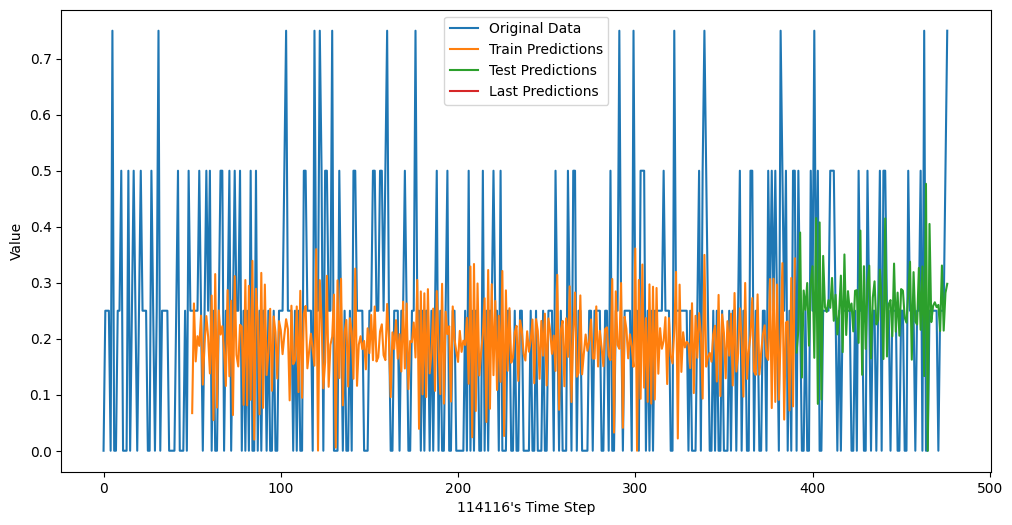

In [129]:
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,), (False,), ]
activation = 'sigmoid'
units = 45
sequence_length = 50

scaled_data_max, last_predict, test_last_predict, random_state = analyze_v1(random_state=random_state,
                                                                            version=t_version,
                                                                            db_file_path=db_file_path,
                                                                            scaler_type=scaler_type,
                                                                            layers=layers,
                                                                            activation=activation,
                                                                            units=units,
                                                                            sequence_length=sequence_length,
                                                                            verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

['1177,1176,1175,1174,1173,1172,1171,1170,1169,1168,1167,1166,1165,1164,1163,1162,1161,1160,1159,1158,1157,1156,1155,1154,1153,1152,1151,1150,1149,1148,1147,1146,1145,1144,1143,1142,1141,1140,1139,1138,1137,1136,1135,1134,1133,1132,1131,1130,1129,1128,1127,1126,1125,1124,1123,1122,1121,1120,1119,1118,1117,1116,1115,1114,1113,1112,1111,1110,1109,1108,1107,1106,1105,1104,1103,1102,1101,1100,1099,1098,1097,1096,1095,1094,1093,1092,1091,1090,1089,1088,1087,1086,1085,1084,1083,1082,1081,1080,1079,1078,1077,1076,1075,1074,1073,1072,1071,1070,1069,1068,1067,1066,1065,1064,1063,1062,1061,1060,1059,1058,1057,1056,1055,1054,1053,1052,1051,1050,1049,1048,1047,1046,1045,1044,1043,1042,1041,1040,1039,1038,1037,1036,1035,1034,1033,1032,1031,1030,1029,1028,1027,1026,1025,1024,1023,1022,1021,1020,1019,1018,1017,1016,1015,1014,1013,1012,1011,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001,1000,999,998,997,996,995,994,993,992,991,990,989,988,987,986,985,984,983,982,981,980,979,978,977,976,975,974,973,

/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


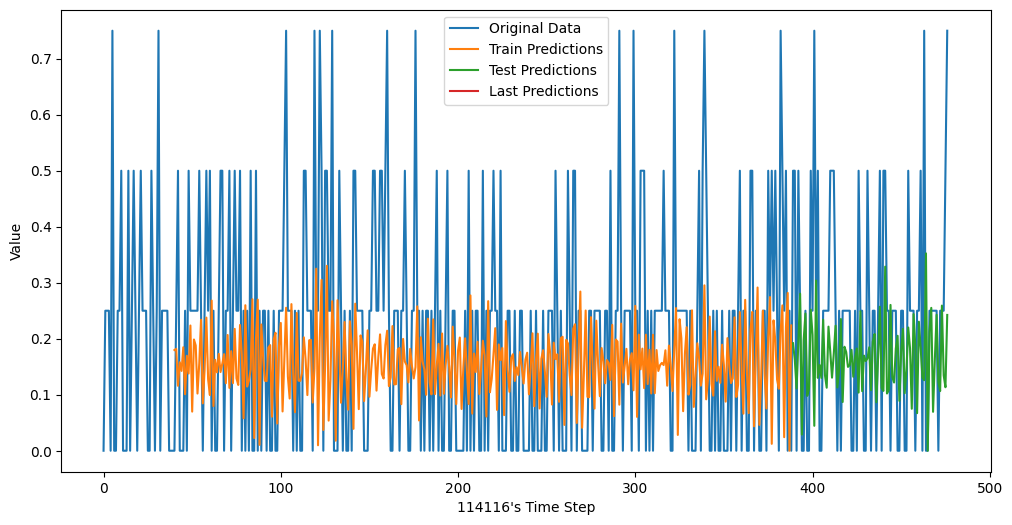

In [132]:
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), (False,), ]
activation = 'sigmoid'
units = 45
sequence_length = 40

scaled_data_max, last_predict, test_last_predict, random_state = analyze_v1(random_state=random_state,
                                                                            version=t_version,
                                                                            db_file_path=db_file_path,
                                                                            scaler_type=scaler_type,
                                                                            layers=layers,
                                                                            activation=activation,
                                                                            units=units,
                                                                            sequence_length=sequence_length,
                                                                            verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

['1177,1176,1175,1174,1173,1172,1171,1170,1169,1168,1167,1166,1165,1164,1163,1162,1161,1160,1159,1158,1157,1156,1155,1154,1153,1152,1151,1150,1149,1148,1147,1146,1145,1144,1143,1142,1141,1140,1139,1138,1137,1136,1135,1134,1133,1132,1131,1130,1129,1128,1127,1126,1125,1124,1123,1122,1121,1120,1119,1118,1117,1116,1115,1114,1113,1112,1111,1110,1109,1108,1107,1106,1105,1104,1103,1102,1101,1100,1099,1098,1097,1096,1095,1094,1093,1092,1091,1090,1089,1088,1087,1086,1085,1084,1083,1082,1081,1080,1079,1078,1077,1076,1075,1074,1073,1072,1071,1070,1069,1068,1067,1066,1065,1064,1063,1062,1061,1060,1059,1058,1057,1056,1055,1054,1053,1052,1051,1050,1049,1048,1047,1046,1045,1044,1043,1042,1041,1040,1039,1038,1037,1036,1035,1034,1033,1032,1031,1030,1029,1028,1027,1026,1025,1024,1023,1022,1021,1020,1019,1018,1017,1016,1015,1014,1013,1012,1011,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001,1000,999,998,997,996,995,994,993,992,991,990,989,988,987,986,985,984,983,982,981,980,979,978,977,976,975,974,973,

/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


add layter [1]
Bidirectional = False


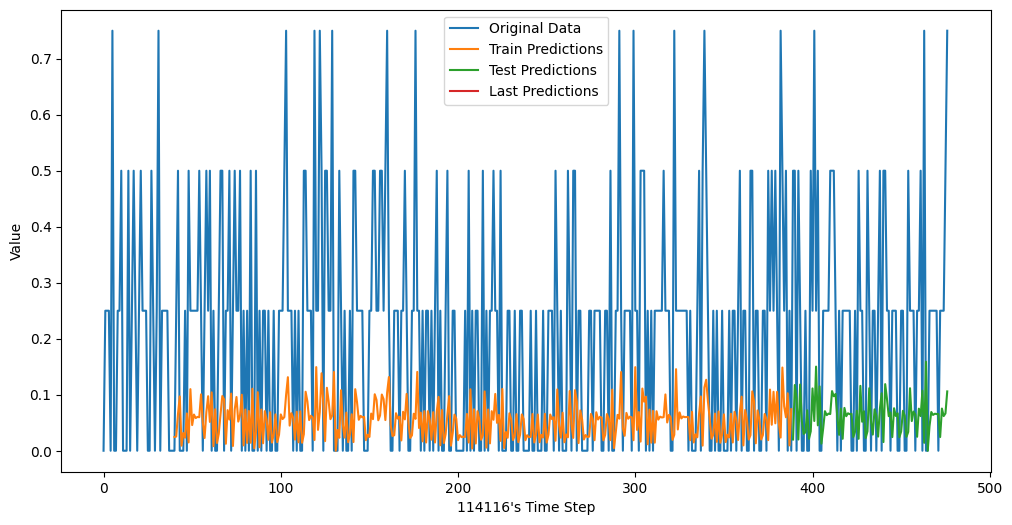

In [133]:
db_file_path = '../db/metrics.db'
random_state = 114116
scaler_type=ScalerType.PRIVATE
# layer information
layers = [(True,), (False,), ]
activation = 'sigmoid'
units = 45
sequence_length = 40

scaled_data_max, last_predict, test_last_predict, random_state = analyze_v1(random_state=random_state,
                                                                            version=t_version,
                                                                            db_file_path=db_file_path,
                                                                            scaler_type=scaler_type,
                                                                            layers=layers,
                                                                            activation=activation,
                                                                            units=units,
                                                                            sequence_length=sequence_length,
                                                                            verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(results, f"now {datetime.now()}")

In [61]:
scaled_data_max, last_predict, random_state
# predict_result.append((scaled_data_max, last_predict, random_state, 3, 50))
for result in predict_result:
    print(result)

(np.float64(3.0), array([[1.13702381]]), 114116, 3, 50)
(np.float64(3.0), array([[0.90072536]]), 114116, 4, 25)
(np.float64(3.0), array([[0.76019865]]), 114116, 2, 25)
(np.float64(3.0), array([[0.59137869]]), 114116, 1, 16, 30)
(np.float64(3.0), array([[0.82943648]]), array([[0.24559736]]), 114116, 1, 16, 30)
(np.float64(3.0), array([[0.64746177]]), array([[0.21640897]]), 114116, 2, 25, 30)
(np.float64(3.0), array([[0.48156992]]), array([[0.06906062]]), 114116, 1, 30, 30)
(np.float64(3.0), array([[1.15814602]]), array([[0.12485385]]), 114116, 2, 45, 50)


['1177,1176,1175,1174,1173,1172,1171,1170,1169,1168,1167,1166,1165,1164,1163,1162,1161,1160,1159,1158,1157,1156,1155,1154,1153,1152,1151,1150,1149,1148,1147,1146,1145,1144,1143,1142,1141,1140,1139,1138,1137,1136,1135,1134,1133,1132,1131,1130,1129,1128,1127,1126,1125,1124,1123,1122,1121,1120,1119,1118,1117,1116,1115,1114,1113,1112,1111,1110,1109,1108,1107,1106,1105,1104,1103,1102,1101,1100,1099,1098,1097,1096,1095,1094,1093,1092,1091,1090,1089,1088,1087,1086,1085,1084,1083,1082,1081,1080,1079,1078,1077,1076,1075,1074,1073,1072,1071,1070,1069,1068,1067,1066,1065,1064,1063,1062,1061,1060,1059,1058,1057,1056,1055,1054,1053,1052,1051,1050,1049,1048,1047,1046,1045,1044,1043,1042,1041,1040,1039,1038,1037,1036,1035,1034,1033,1032,1031,1030,1029,1028,1027,1026,1025,1024,1023,1022,1021,1020,1019,1018,1017,1016,1015,1014,1013,1012,1011,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001,1000,999,998,997,996,995,994,993,992,991,990,989,988,987,986,985,984,983,982,981,980,979,978,977,976,975,974,973,

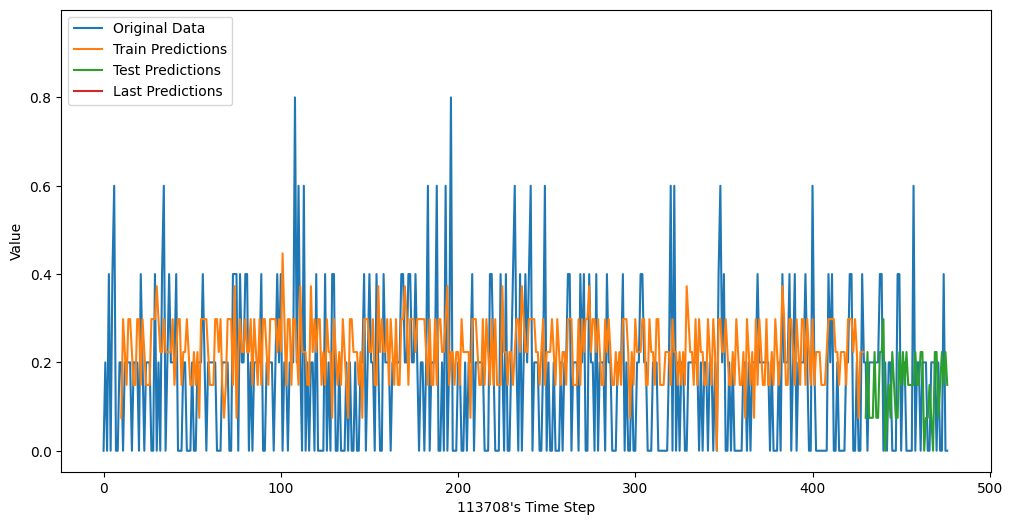

In [29]:
db_file_path = '../db/metrics.db'
random_state = 113708
predict_scale = 10000000
predict_round = 8
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50

results = analyze_v1(random_state=random_state,
                                                         version=t_version,
                                                         predict_round=predict_round,
                                                         db_file_path=db_file_path,
                                                         scaler_type=scaler_type,
                                                         layer=layer,
                                                         activation=activation,
                                                         units=units,
                                                         verbose=0)
predict_result.append((results["scaled_data_max"],
                       results["last_predict"],
                       results["test_last_predict"],
                       results["random_state"],
                       units,
                       sequence_length,
                       activation))
print(result, f"now {datetime.now()}")

In [77]:
for result in predict_result:
    print(result)

(np.float64(3.0), array([[1.13702381]]), 114116, 3, 50)
(np.float64(3.0), array([[0.90072536]]), 114116, 4, 25)
(np.float64(3.0), array([[0.76019865]]), 114116, 2, 25)
(np.float64(3.0), array([[0.59137869]]), 114116, 1, 16, 30)
(np.float64(3.0), array([[0.82943648]]), array([[0.24559736]]), 114116, 1, 16, 30)
(np.float64(3.0), array([[0.64746177]]), array([[0.21640897]]), 114116, 2, 25, 30)
(np.float64(3.0), array([[0.48156992]]), array([[0.06906062]]), 114116, 1, 30, 30)
(np.float64(3.0), array([[1.15814602]]), array([[0.12485385]]), 114116, 2, 45, 50)


['1177,1176,1175,1174,1173,1172,1171,1170,1169,1168,1167,1166,1165,1164,1163,1162,1161,1160,1159,1158,1157,1156,1155,1154,1153,1152,1151,1150,1149,1148,1147,1146,1145,1144,1143,1142,1141,1140,1139,1138,1137,1136,1135,1134,1133,1132,1131,1130,1129,1128,1127,1126,1125,1124,1123,1122,1121,1120,1119,1118,1117,1116,1115,1114,1113,1112,1111,1110,1109,1108,1107,1106,1105,1104,1103,1102,1101,1100,1099,1098,1097,1096,1095,1094,1093,1092,1091,1090,1089,1088,1087,1086,1085,1084,1083,1082,1081,1080,1079,1078,1077,1076,1075,1074,1073,1072,1071,1070,1069,1068,1067,1066,1065,1064,1063,1062,1061,1060,1059,1058,1057,1056,1055,1054,1053,1052,1051,1050,1049,1048,1047,1046,1045,1044,1043,1042,1041,1040,1039,1038,1037,1036,1035,1034,1033,1032,1031,1030,1029,1028,1027,1026,1025,1024,1023,1022,1021,1020,1019,1018,1017,1016,1015,1014,1013,1012,1011,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001,1000,999,998,997,996,995,994,993,992,991,990,989,988,987,986,985,984,983,982,981,980,979,978,977,976,975,974,973,

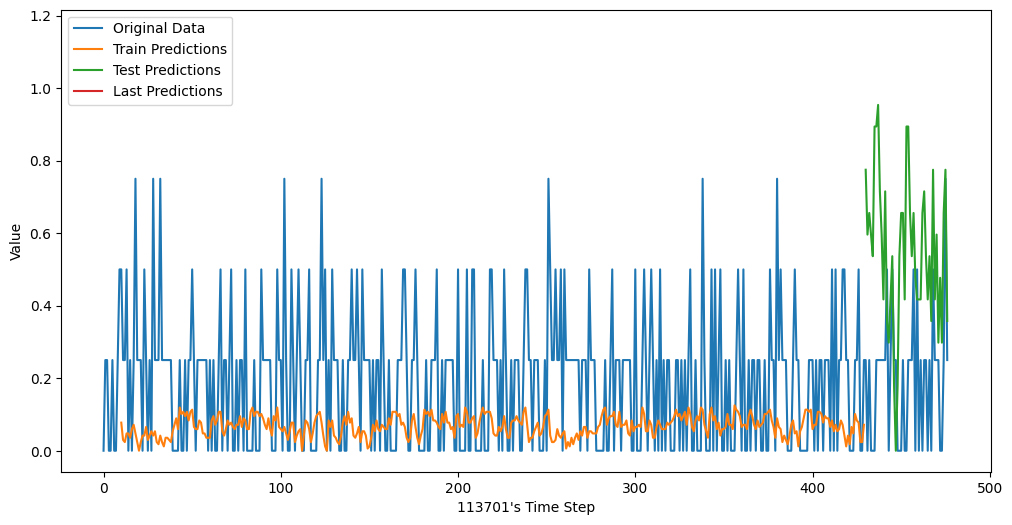

In [30]:
db_file_path = '../db/metrics.db'
random_state = 113701
predict_scale = 10000000
predict_round = 8
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50

scaled_data_max, last_predict, random_state = analyze_v1(random_state=random_state,
                                                         version=t_version,
                                                         predict_round=predict_round,
                                                         db_file_path=db_file_path,
                                                         scaler_type=scaler_type,
                                                         layer_count=layer_count,
                                                         activation=activation,
                                                         units=units,
                                                         verbose=0)

In [26]:
db_file_path = '../db/metrics.db'
random_state = 113799
# predict_scale = 10000000
predict_scale = 1000000
predict_round = 7
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50
analyze_v1(random_state=random_state, version=version, db_file_path=db_file_path, verbose=0)

[]


(-1, '', 113799)

In [ ]:
### 최종 결과 입니다. (113789)
db_file_path = '../db/metrics.db'
random_state = 113789
predict_scale = 10000000
predict_round = 7
scaler_type=ScalerType.PRIVATE
# layer information
layer_count = 3
activation = 'sigmoid'
units = 50
analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

In [ ]:
### 최종 결과 입니다. (113789)
db_file_path = '../db/metrics.db'
random_state = 113700
predict_scale = 10000000
predict_round = 7
layer_count = 3
activation = 'sigmoid'
units = 50
scaler_type=ScalerType.PRIVATE
analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

In [ ]:
db_file_path = '../db/metrics.db'
random_state = 113705
# predict_scale = 10000000
predict_scale = 1000000
predict_round = 7
layer_count = 3
activation = 'sigmoid'
units = 50
scaler_type=ScalerType.PRIVATE
analyze_v1(random_state=random_state,
           version=version,
           predict_round=predict_round,
           db_file_path=db_file_path,
           scaler_type=scaler_type,
           layer_count=layer_count,
           activation=activation,
           units=units,
           verbose=0)

In [8]:
"""
version TEXT, random_state INTEGER, possibility FLOAT, max INTEGER
"""
def insert_possi(version, max, possi, random_state):
    table_name='rndforest_possi'
    db_file_path='../db/metrics.db'
    sql = f'insert into {table_name} (version, random_state, possibility, max) values(\\"{version}\\", {random_state}, {possi}, {max});'
    !echo "{sql}" | sqlite3 {db_file_path}

print(f'Current Step : [now {datetime.now()}]')

Current Step : [now 2025-06-20 22:43:02.880812]


In [26]:
def get_possibility(random_states, db_file_path, layer_count, activation, units, scaler_type, sequence_length=10):
    random_state_begin = 3700
    # predict_scale = 10000000
    predict_scale = 1000000
    predict_round = 7
    results = []
    for random_state in tqdm(random_states):
        scaled_data_max, last_predict, random_state = analyze_v1(random_state=random_state,
                                                                 version=version,
                                                                 predict_round=predict_round,
                                                                 db_file_path=db_file_path,
                                                                 scaler_type=scaler_type,
                                                                 layer_count=layer_count,
                                                                 activation=activation,
                                                                 units=units,
                                                                 draw_graph=False,
                                                                 sequence_length=sequence_length,
                                                                 verbose=0)
        results.append((scaled_data_max, last_predict, random_state))
        if last_predict > 1.7:
            print(scaled_data_max, last_predict, random_state)
    return results

In [10]:
results=[]
#113780에서 5씩 증가

db_file_path = '../db/metrics.db'
layer_count = 3
activation = 'sigmoid'
units = 50
gap = 5
scaler_type = ScalerType.PRIVATE
random_states = range(random_state_begin, random_state_begin+gap)
results = get_possibility(random_states=random_states,
                          db_file_path=db_file_path,
                          layer_count=layer_count,
                          activation=activation,
                          units=units,
                          scaler_type=scaler_type)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [11:18<00:00, 135.68s/it]


In [ ]:
results=[]
#113780에서 5씩 증가

db_file_path = '../db/metrics.db'
layer_count = 3
activation = 'sigmoid'
units = 50
scaler_type=ScalerType.PRIVATE
rows = "\
('74692', '3705', 10)\
('74702', '3715', 10)\
('74704', '3717', 10)\
('74712', '3725', 10)\
('74721', '3734', 10)\
('74740', '3753', 10)\
('74743', '3756', 10)\
('74748', '3761', 10)\
('74757', '3770', 10)\
('74775', '3788', 10)\
('74777', '3790', 10)\
('74779', '3792', 10)\
('74698', '3711', 11)\
('74715', '3728', 11)\
('74716', '3729', 11)\
('74730', '3743', 11)\
('74746', '3759', 11)\
('74778', '3791', 11)\
('74781', '3794', 11)\
('74722', '3735', 12)\
('74766', '3779', 12)\
('74767', '3780', 12)\
('74782', '3795', 12)\
('74696', '3709', 13)\
('74699', '3712', 13)\
('74711', '3724', 13)\
('74723', '3736', 13)\
('74729', '3742', 13)\
('74720', '3733', 14)\
"
# ('74689', '3702', 10)\

random_states = []
data_rows_str = rows.replace("(","")
data_rows = data_rows_str.split(")")
for row in data_rows:
    if len(row) > 0:
        row = row.replace("\'","")
        cols = row.split(", ")
        if len(cols) > 0:
            random_states.append(int(cols[1]))
random_states=[3731,3786,3702,3715,3734,3753,3761,3770]
print(random_states)
results = get_possibility(random_states=random_states,
                          db_file_path=db_file_path,
                          layer_count=layer_count,
                          activation=activation,
                          units=units,
                          sequence_length=30,
                          scaler_type=scaler_type)

[3731, 3786, 3702, 3715, 3734, 3753, 3761, 3770]


  0%|                                                                                             | 0/8 [00:00<?, ?it/s]

In [28]:
for result in results:
    print(result)

(np.float64(3.0), array([[0.51065975]]), 3731)
(np.float64(4.0), array([[0.03436218]]), 3786)
(np.float64(4.999999998), array([[0.98191944]]), 3702)
(np.float64(3.0), array([[1.15016282]]), 3715)
(np.float64(3.0), array([[1.67712224]]), 3734)
(np.float64(4.0), array([[-0.16663458]]), 3753)
(np.float64(4.0), array([[0.22691065]]), 3761)
(np.float64(3.0), array([[1.05514777]]), 3770)


In [19]:
for result in results:
    print(result)
    insert_possi(version=version, max=result[0], possi=result[1][0][0], random_state=result[2])

(np.float64(3.0), array([[0.65072489]]), 3731)
(np.float64(4.0), array([[0.50776754]]), 3786)
(np.float64(4.999999998), array([[0.55112202]]), 3702)
(np.float64(3.0), array([[0.77709711]]), 3715)
(np.float64(3.0), array([[1.09201658]]), 3734)
(np.float64(4.0), array([[1.04803503]]), 3753)
(np.float64(4.0), array([[0.75670734]]), 3761)
(np.float64(3.0), array([[0.96134448]]), 3770)


In [ ]:

actual_numbers = [
    [1175, 3, 4, 6, 8, 32, 42],
    [1174, 8, 11, 14, 17, 36, 39],
    [1173, 1, 5, 18, 20, 30, 35],
    [1172, 7, 9, 24, 40, 42, 44],
    [1171, 3, 6, 7, 11, 12, 17],
    [1170, 3, 13, 28, 34, 38, 42],
    [1169, 5, 12, 24, 26, 39, 42],
    [1168, 9, 21, 24, 30, 33, 37],
    [1167, 8, 23, 31, 35, 39, 40],
]